In [32]:
#!python prepare_data_spleen.py

In [33]:
from cnn.model import build_net
from cnn.input import Dataloader, SpleenDataset, get_train_val_filenames
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import random

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
  except RuntimeError as e:
    print(e)

In [49]:
data_path = './data/Task09_Spleen_2D'

image_size = 128
batch_size = 32
num_classes = 2

In [50]:
train_images_filepaths, val_images_filepaths, train_labels_filepaths, val_labels_filepaths = get_train_val_filenames(data_path)

train_dataset = SpleenDataset(train_images_filepaths, train_labels_filepaths)
val_dataset = SpleenDataset(val_images_filepaths, val_labels_filepaths)

train_dataloader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = Dataloader(val_dataset, batch_size=batch_size, shuffle=False)

In [51]:
len(train_dataset)

832

In [52]:
len(train_dataloader)

26

(128, 128, 1)
(128, 128, 1)


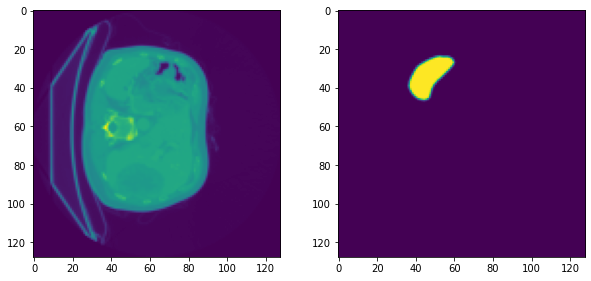

In [53]:
id = random.randint(0, len(train_dataset))
image, label = train_dataset[id]

print(image.shape)
print(label.shape)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(label)

In [54]:
model = build_net((image_size, image_size, 1), num_classes, fn_dict=None, net_list=None)
#model.summary()

In [56]:
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image

# plot_model(model,
#            to_file='model.png',
#            show_shapes=True,
#            show_layer_names=True,
#            rankdir='TB'
#             )
# Image('model.png')

In [57]:
history = model.fit(
    train_dataloader,
    validation_data=val_dataloader,
    epochs=100,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", mode="min", verbose=1, patience=3
        ),
        ModelCheckpoint(
            "best_model.h5",
            save_best_only=True,
            monitor="val_loss",
            mode="min",
        ),
        ReduceLROnPlateau(),
    ],
)

Epoch 1/100
26/26 [==============================] - 6s 105ms/step - loss: 0.9800 - gen_dice_coef: 0.0200 - val_loss: 0.9811 - val_gen_dice_coef: 0.0189 - lr: 1.0000e-04
Epoch 2/100
26/26 [==============================] - 2s 82ms/step - loss: 0.9731 - gen_dice_coef: 0.0269 - val_loss: 0.9728 - val_gen_dice_coef: 0.0272 - lr: 1.0000e-04
Epoch 3/100
26/26 [==============================] - 2s 82ms/step - loss: 0.9617 - gen_dice_coef: 0.0383 - val_loss: 0.9637 - val_gen_dice_coef: 0.0363 - lr: 1.0000e-04
Epoch 4/100
26/26 [==============================] - 2s 81ms/step - loss: 0.9523 - gen_dice_coef: 0.0477 - val_loss: 0.9564 - val_gen_dice_coef: 0.0436 - lr: 1.0000e-04
Epoch 5/100
26/26 [==============================] - 2s 82ms/step - loss: 0.9438 - gen_dice_coef: 0.0562 - val_loss: 0.9489 - val_gen_dice_coef: 0.0511 - lr: 1.0000e-04
Epoch 6/100
26/26 [==============================] - 2s 82ms/step - loss: 0.9335 - gen_dice_coef: 0.0665 - val_loss: 0.9395 - val_gen_dice_coef: 0.0605 - 

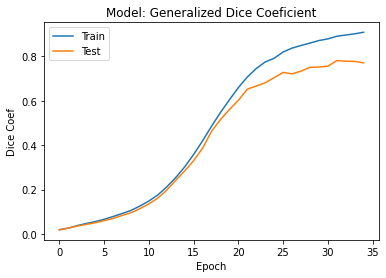

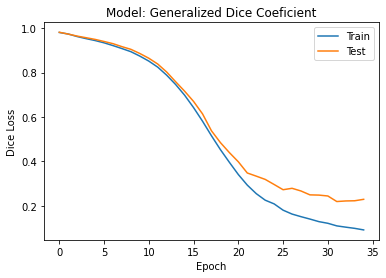

In [59]:
# plotting the dice coeff results (accuracy) as a function of the number of epochs
plt.figure()
plt.plot(history.history['gen_dice_coef'])
plt.plot(history.history['val_gen_dice_coef'])
plt.title('Model: Generalized Dice Coeficient')
plt.ylabel('Dice Coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plotting the dice coeff results (loss function) as a function of the number of epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model: Generalized Dice Coeficient')
plt.ylabel('Dice Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
model.load_weights('best_model.h5')